In [2]:
import sys
sys.path.insert(1, 'D:\Master\Blok3\AAS') #add path of toolbox

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, optimize, interpolate
from matplotlib.ticker import MaxNLocator
#custom modules
import importlib as il
from toolbox import as_toolbox as ast
from toolbox import vis
from toolbox import fits
from iminuit import Minuit
from toolbox.ExternalFunctions import UnbinnedLH
import urllib
import dtale
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker

## 0 

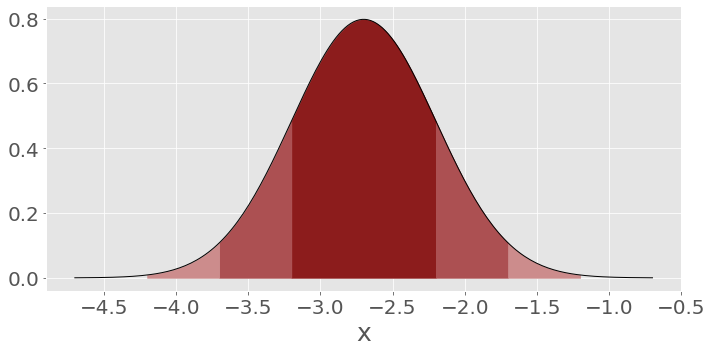

In [250]:
mu, sig = -2.7, np.sqrt(0.25)
def gauss(x): return stats.norm.pdf(x, mu, sig)
x = np.linspace(mu-4*sig,mu+4*sig,200)
x_sig1 = np.linspace(mu-sig, mu+sig,100)
x_sig2l= np.linspace(mu-2*sig, mu-1*sig,100)
x_sig2r= np.linspace(mu+1*sig, mu+2*sig,100)
x_sig3l= np.linspace(mu-3*sig, mu-2*sig,100)
x_sig3r= np.linspace(mu+2*sig, mu+3*sig,100)

color = vis.Color_palette(1)[0]
fig, ax = vis.nice_plot(
    x, gauss(x), save_plot=False, figname='Gauss.pdf', color='k',
    linewidth=1, fill_under_curve=False, fill_color='k', show_plot = False)
ax.fill_between(x_sig1, gauss(x_sig1), color = '#8c1c1c')
ax.fill_between(x_sig2l, gauss(x_sig2l), color = '#ac5052')
ax.fill_between(x_sig2r, gauss(x_sig2r), color = '#ac5052')
ax.fill_between(x_sig3r, gauss(x_sig3r), color = '#cc8c8c')
ax.fill_between(x_sig3l, gauss(x_sig3l), color = '#cc8c8c')

fig.tight_layout()
fig.savefig('Figs/Gauss.pdf', dpi = 80)
fig

# Income

* Create classifier to separate low income from high income

## Load/analyse Data 

In [5]:
f = urllib.request.urlopen(
    'https://www.nbi.dk/~koskinen/Teaching/data/earning_potential_train_test.txt')
Inc_data = pd.read_csv(f)
Inc_data.head(3)

,age,education,gender,hours-per-week,earning
0,39,13,0,40,<=50K
1,50,13,0,13,<=50K
2,38,9,0,40,<=50K


In [6]:
#Are there any nans
Inc_data.isnull().any() #nope

age               False
education         False
gender            False
hours-per-week    False
earning           False
dtype: bool

In [7]:
#This is a classification problem, so lets turn the earning in a binary variable 'target'
#0 is lower income, 1 is higher income
income_dict = {' <=50K':0, ' >50K':1}
Inc_data['target'] = Inc_data['earning'].map(income_dict)
Inc_data.head(10)

,age,education,gender,hours-per-week,earning,target
0,39,13,0,40,<=50K,0
1,50,13,0,13,<=50K,0
2,38,9,0,40,<=50K,0
3,53,7,0,40,<=50K,0
4,28,13,1,40,<=50K,0
5,37,14,1,40,<=50K,0
6,49,5,1,16,<=50K,0
7,52,9,0,45,>50K,1
8,31,14,1,50,>50K,1
9,42,13,0,40,>50K,1


In [8]:
#g = sns.PairGrid(Inc_data.iloc[:,:-1], hue="earning")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [14]:
#sns.pairplot(Inc_data.iloc[:,:-1], hue="earning", height=2.5)

## 1 a
precision of selecting high earners with less than 15% low earners

### Train and compare classifiers

No feature scaling is required for decision trees!

In [100]:
#Split data in train and test set
X, y = Inc_data.iloc[:,:-2], Inc_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.48, random_state=1)
#We have to exclude at least 500 entries of each class 
#from the training set for a later task
np.count_nonzero(y_test==0), np.count_nonzero(y_test==1)

(1658, 502)

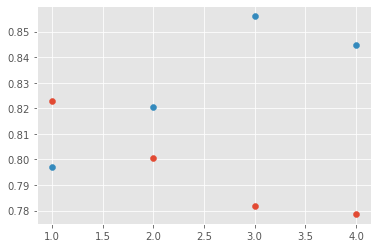

In [121]:
Test_score, Train_score = [], []
# fit model no training data
for i in range(1,5):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
         max_depth=i, random_state=0).fit(X_train, y_train)
    Test_score.append(clf.score(X_test, y_test))
    Train_score.append(clf.score(X_train, y_train))
plt.scatter(np.arange(1,5), np.array(Test_score))
plt.scatter(np.arange(1,5), np.array(Train_score))

As asked in the task, we are interested in the precision on the training set.

### Precision 

In [60]:
def True_Positive(y_pred, y_true):
    """Compute the number of true positives. 
    Where positive is 1."""
    mask_pred = y_pred==1
    mask_true = y_true==1
    mask_TP = mask_pred&mask_true
    return np.count_nonzero(mask_TP)

In [123]:
final_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
         max_depth=1, random_state=0).fit(X_train, y_train)
y_train_pred = final_clf.predict(X_train)
TP = True_Positive(y_train_pred, y_train)
Tot_pos = np.count_nonzero(y_train_pred)#all predicted as positive
Precision = TP/Tot_pos
print(f"precision on the training set: {Precision:3.2f}")

precision on the training set: 0.66


### Decision score hist

In [124]:
np.count_nonzero(y_test==0), np.count_nonzero(y_test==1)

(1658, 502)

In [125]:
X_low = X_test[y_test==0]#low
X_high = X_test[y_test==1]#high
#we select 500 points from each class randomly
_,X_low_500,_,_ = train_test_split(X_low, X_low, test_size = 500, random_state = 1)
_,X_high_500,_,_ = train_test_split(X_high, X_high, test_size = 500, random_state = 1)
ds_500_low = final_clf.decision_function(X_low_500)
ds_500_high = final_clf.decision_function(X_high_500)

In [137]:
vis.nice_histogram?

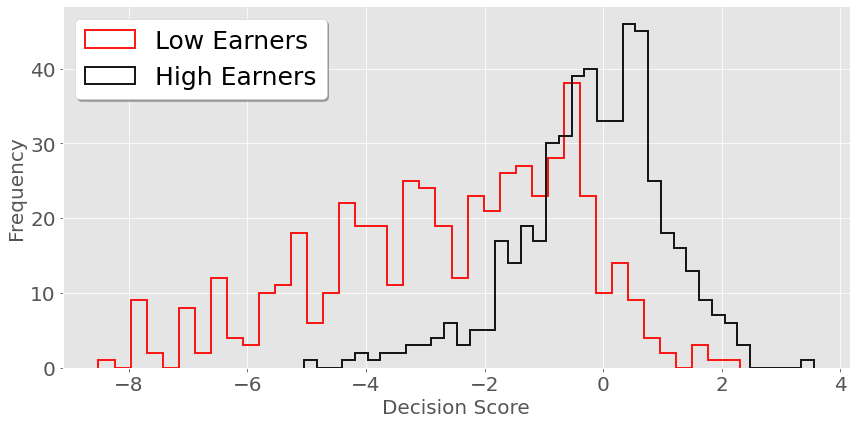

In [249]:
x, y, binwidth, fig, ax = vis.nice_histogram(
    ds_500_low, 40, color_hist='r', data_label_hist='Low Earners')
x, y, binwidth, fig, ax = vis.nice_histogram(
    ds_500_high, 40, color_hist='k', figure = fig, axis = ax, plot_legend=True,
    data_label_hist='High Earners', xlabel="Decision Score", legend_fs=25, 
    save = True, figname = "Figs/Histogram1a.pdf", legend_loc=2 )
fig

## 1b 

### Rank variables by feature importance 

In [134]:
feature_importance = final_clf.feature_importances_
feat_imp_ind = np.argsort(feature_importance)[::-1]
X.columns[feat_imp_ind], feature_importance[feat_imp_ind]

(Index(['age', 'education', 'hours-per-week', 'gender'], dtype='object'),
 array([0.45799421, 0.34254827, 0.13858722, 0.0608703 ]))

Age and education have a similar importance, hours-per-week has a 3 times lower importance than age and gender is only half as important as hours per week

### Overtraining 

Overtraining can be identified by comparing train and validation loss. The validation loss, if representative for the distribution of the real world data, indicates the capacity of the model to generalize to previously unseen data. Starting with a small model and increasing it gradually results in a decreasing training and validation loss. However, above a certain model size the validation loss will start to increase whil the training loss will decrease further. This is known as overtraining or overfitting.\\
There are many ways to avoid overfitting. Here are just some examples: 
* Dropout: used in neural networks, during training a fraction of the neurons (10-20 \%) is randomly switched off
* Early Stopping: In early stopping the validation loss is observed during training. If the validation loss does not decrease during a specified number of epochs, training is stopped, and model parameters corresponding to the lowest validation loss are stored
* Decreasing the number of parameters
* Regularization: This adds an additional term to the loss function which punishes high values of parameters. This prevents the network from learning more complex functions

## 1c

In [135]:
url_real = "https://www.nbi.dk/~koskinen/Teaching/data/earning_potential_real.txt"
Real_data = pd.read_csv(urllib.request.urlopen(url_real))
Real_data.head(3)

,ID,age,education,gender,hours-per-week
0,0,40,9,1,40
1,1,28,13,1,48
2,2,49,10,1,30


In [136]:
#Are there any nans
Real_data.isnull().any() #nope

ID                False
age               False
education         False
gender            False
hours-per-week    False
dtype: bool

In [145]:
y_real_pred = final_clf.predict(Real_data.iloc[:,1:])
np.sum(y_real_pred), len(y_real_pred)

(546, 3612)

In [162]:
Real_data['earning_prediction'] = y_real_pred #store prediction
mask0 = Real_data.earning_prediction==0
#separate
pred_low = Real_data[mask0]
pred_high = Real_data[~mask0]
#select IDs
ID_low = pred_low.ID
ID_high = pred_high.ID
#save
np.savetxt('kiril_klein.low_ID.txt',ID_low,fmt='%i')
np.savetxt('kiril_klein.high_ID.txt',ID_high,fmt='%i')

# Problem 2 

In [298]:
Data_crashes = pd.read_excel('cpd-crash-incidents.xlsx', engine='openpyxl')
Data_crashes.head(3)

,tamainid,location_description,rdfeature,rdcharacter,rdclass,rdconfigur,rdsurface,rdcondition,lightcond,weather,...,fatalities,injuries,month,contrfact1,contrfact2,contributing_factor,vehicleconcat1,vehicleconcat2,vehicleconcat3,vehicle_type
0,20603,140 FEET FROM PVA (2234 WALNUT ST),NO SPECIAL FEATURE,"STRAIGHT,LEVEL",PUBLIC VEHICULAR AREA,"TWO-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLOUDY,...,No,No,1,NaN,NONE,NONE,"PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY"
1,20606,.10 MILES FROM PVA OF 150 WRENN DR,NO SPECIAL FEATURE,"STRAIGHT,LEVEL",PUBLIC VEHICULAR AREA,"ONE-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,1,NaN,NONE,NONE,"SPORT UTILITY,VAN","SPORT UTILITY,VAN","SPORT UTILITY,VAN","SPORT UTILITY,VAN"
2,20607,30 FEET FROM SR1300(KILDAIRE FARM RD),RELATED TO INTERSECTION,"STRAIGHT,LEVEL",STATE SECONDARY ROUTE,"TWO-WAY,DIVIDED,UNPROTECTED MEDIAN",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,1,NaN,NONE,NONE,"PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR"


## 2a 

In [ ]:
#to give it the right format i.e. -78.29837 and 35.324
Dc = Data_crashes.copy()
Dc["lat"]= Data_crashes["lat"].map(str)
Dc["lon"]= Data_crashes["lon"].map(str)
#remove the second decimal point
Dc["lat"] = Dc["lat"].str.replace('.','')
Dc["lon"] = Dc["lon"].str.replace('.','')
#place decimal point after two digits
#only first time this combi occurs should be replaced
Dc["lat"] = Dc["lat"].str.replace('35','35.',1)
mask_36 = Dc.lat.str[:2]=="36"
Dc.loc[mask_36,"lat"] = Dc.loc[mask_36, "lat"].str.replace('36','36.',1)
Dc["lon"] = Dc["lon"].str.replace('-78','-78.',1)
Dc["lon"] = Dc["lon"].str.replace('-79','-79.',1)
#Turn it into float again
Dc["lat"]= Dc["lat"].map(float)
Dc["lon"]= Dc["lon"].map(float)
Dc.lon.head()

### Scatter plot 

In [ ]:
fig,ax = vis.nice_plot( 
    Dc.lon.dropna(), Dc.lat.dropna(), scatter=True, show_plot=False,
    xlabel='Longitude [DD]', ylabel='Latitude [DD]', save_plot=True,
    figname='Figs/scatter2a.pdf', figsize = (8,6))
fig

### Histogram time 

In [328]:
#Create a column that only contains the hour#
hours = Dc.ta_time.apply(lambda x: x.hour)
Dc["hours"] = hours
np.count_nonzero(Dc.hours==23)`

338

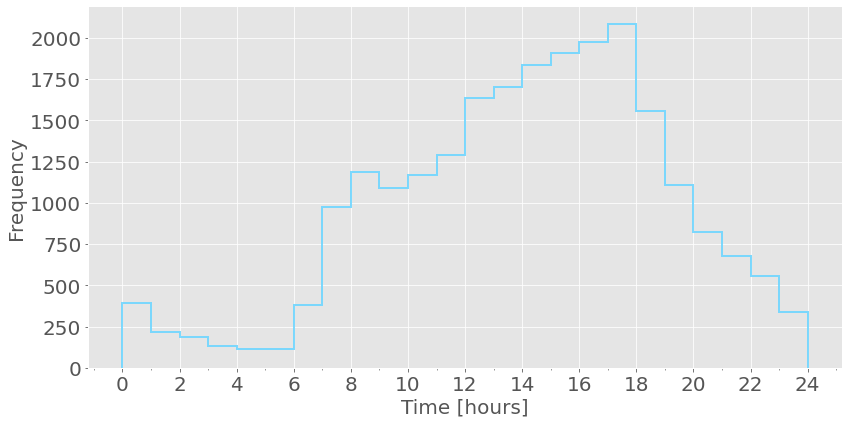

In [357]:
colors = vis.Color_palette(1)
bins = np.arange(0,25)
x, y, binwidth, fig, ax = vis.nice_histogram(
    Dc.hours, bins, save=True, figname='Figs/hour_hist2a.pdf',
    color_hist=colors[0], xlabel='Time [hours]', histtype='step')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig